In [1]:
# check the escape time in UTC
# 'https://www.timeanddate.com/worldclock/converter.html?iso=19620612T050000&p1=224&p2=1440#'
print('''
San Francisco, USA    Mon, 11 Jun 1962 at 22:00 PDT    
UTC, Time Zone        Tue, 12 Jun 1962 at 05:00        
''')


San Francisco, USA    Mon, 11 Jun 1962 at 22:00 PDT    
UTC, Time Zone        Tue, 12 Jun 1962 at 05:00        



In [2]:
import netCDF4
import datetime
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

%matplotlib inline


/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# detailed data over pressure levels (not used)
u_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Aggregations/ncep.reanalysis/uwnd.nc'
v_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Aggregations/ncep.reanalysis/vwnd.nc'

# interpolated data to 10m height 
u_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface_gauss/uwnd.10m.gauss.1962.nc'
v_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/surface_gauss/vwnd.10m.gauss.1962.nc'

# open the datasets
ds_u = netCDF4.Dataset(u_url)
ds_v = netCDF4.Dataset(v_url)

In [4]:
# find 1962, at night of escape, in UTC
t_u  = netCDF4.num2date(ds_u.variables['time'][:], ds_u.variables['time'].units)
t_v  = netCDF4.num2date(ds_v.variables['time'][:], ds_v.variables['time'].units)
(t_idx, ) = np.where(t_u == datetime.datetime(1962, 6, 12, 6, 0))
assert len(t_idx) == 1
assert t_u[t_idx] == t_v[t_idx]
t = t_u[t_idx][0]
t_idx, t

(array([649]), datetime.datetime(1962, 6, 12, 6, 0))

In [5]:
# closest lat. lon
lat_idx = np.argmin((ds_u['lat'][:] - 37)**2)
lon_idx = np.argmin((np.mod(ds_u['lon'][:], 360) - (360-122))**2)
lat, lon = (ds_u['lat'][lat_idx], ds_u['lon'][lon_idx])
(lat_idx, lon_idx), (lat, lon)

((27, 127), (37.1422, 238.125))

In [6]:
# lookup u,v at SFO
u = ds_u.variables['uwnd'][t_idx, lat_idx, lon_idx]
v = ds_v.variables['vwnd'][t_idx, lat_idx, lon_idx]
u, v

(array([ 1.], dtype=float32), array([-1.], dtype=float32))

In [7]:
# create a map of the surroundings to double check location and variation along shore 
U = np.squeeze(
    ds_u.variables['uwnd'][t_idx, (lat_idx - 5):(lat_idx+5), (lon_idx-5):(lon_idx+5)]
)
V = np.squeeze(
    ds_v.variables['vwnd'][t_idx, (lat_idx - 5):(lat_idx+5), (lon_idx-5):(lon_idx+5)]
)
Lat = ds_u.variables['lat'][(lat_idx - 5):(lat_idx+5)]
Lon = ds_u.variables['lon'][(lon_idx - 5):(lon_idx+5)]

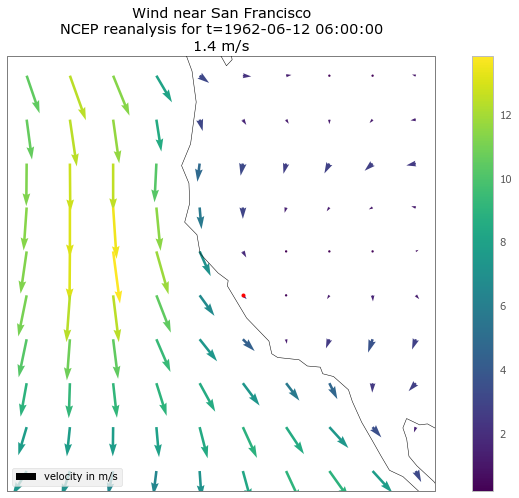

In [8]:
# Create a plot in the popular projection of the day
fig, ax = plt.subplots(
    figsize=(13, 8),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)
# quiver plot
qv = ax.quiver(Lon, Lat, U, V, np.sqrt(U**2+V**2), label='velocity in m/s')
ax.legend(loc='lower left')

# wind at SFO
wind_at_sfo = "{:.1f} {}".format(
    np.sqrt(u ** 2 + v**2)[0], 
    ds_u.variables['uwnd'].units
)
# annotations don't work in projections so all information in the title
ax.set_title('Wind near San Francisco\n' + 'NCEP reanalysis for t={}\n'.format(t) + wind_at_sfo)
# mark the POI 
ax.plot(lon-360, lat, 'r.')
# coastline for reference
ax.coastlines()
# scale
_ = plt.colorbar(qv, ax=ax)
